####  Notebook on GP Regression on Solar irradiation dataset with GPy and PySTAN

In [548]:
%matplotlib inline
import  matplotlib
import matplotlib.pyplot as plt
import pystan

In [568]:
import numpy as np
import scipy.io as sio

In [569]:
solar_raw_data = np.genfromtxt('solar_data.txt', delimiter=',')
X = solar_raw_data[:, 0:1]
Y = solar_raw_data[:, 2:3]

In [570]:
Y = (Y - Y.mean()) / Y.std()

In [571]:
X_train = X.copy()
Y_train = Y.copy()

In [572]:
X_test, Y_test = [], [] 
# X_train, Y_train = [], []

In [573]:
intervals = ((1620, 1650), (1700, 1720), (1780, 1800), (1850, 1870), (1930, 1950))

In [574]:
intervals = ((1620, 1650), (1700, 1720), (1780, 1800), (1850, 1870), (1930, 1950))
for low, up in intervals:
    ind = np.logical_and(X_train.flatten() > low, X_train.flatten() < up)
    X_test.append(X_train[ind])
    Y_test.append(Y_train[ind])
    X_train = np.delete(X_train, np.where(ind)[0], axis=0)
    Y_train = np.delete(Y_train, np.where(ind)[0], axis=0)
X_test, Y_test = np.vstack(X_test), np.vstack(Y_test)

In [575]:
print(X_train.shape)
print(X_test.shape)
print(X.shape)

(281, 1)
(110, 1)
(391, 1)


In [576]:
lik = GPy.likelihoods.Gaussian()

In [577]:
kern_mat52= GPy.kern.Matern52(1, lengthscale=10)
kern_rbf = GPy.kern.RBF(1, lengthscale=1)

In [578]:
M = 50
M1= 100
M2 = 500

In [579]:
def plot(m, X, ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 2)
    xtest = np.linspace(X.min(), X.max(), 300)[:, None]
    mu, var = m.predict(xtest)
    line, = ax.plot(xtest, mu, lw=1.5)
    ax.plot(xtest, mu + 2*np.sqrt(var), color=line.get_color())
    ax.plot(xtest, mu - 2*np.sqrt(var), color=line.get_color())
    ax.plot(m.X, m.Y, 'r.')
#     ax.plot(X_test, Y_test, 'g.')
    for i in intervals:
        ax.plot([i[0], i[0]], [-2, 3], 'b--')
        ax.plot([i[1], i[1]], [-2, 3], 'b--')
    ax.set_ylim(-2, 3)
    ax.set_xlim(X.min(), X.max())


def plot_raw(m, X, ax=None):
    if ax is None:
        f, ax = plt.subplots(1, 2)
    xtest = np.linspace(X.min(), X.max(), 300)[:, None]
    mu_f, var_f = m._raw_predict(xtest)
    line, = ax.plot(xtest, mu_f, lw=1.5)
    ax.plot(xtest, mu_f + 2*np.sqrt(var_f), color=line.get_color())
    ax.plot(xtest, mu_f - 2*np.sqrt(var_f), color=line.get_color())
    ax.plot(m.X, m.Y, 'r.')
    ax.plot(X_test, Y_test, 'g.')
    for i in intervals:
        ax.plot([i[0], i[0]], [-2, 3], 'b--')
        ax.plot([i[1], i[1]], [-2, 3], 'b--')
    ax.set_ylim(-2, 3)
    ax.set_xlim(X.min(), X.max())

In [580]:
def RMSE(m, X_test, Y_test):
    Y_star, var_star = m.predict(X_test)
    rmse = np.sqrt(np.mean(np.square(Y_star - Y_test)))
    return rmse

def NMSE(m, X_test, Y_test):
    Y_star, var_star = m.predict(X_test)
    nmse = np.mean(np.square(Y_star - Y_test)) / np.mean(np.square(Y_test - np.mean(Y_test)))
    return nmse

def MLPPD(m, X_test, Y_test):
    Y_star, var_star = m.predict(X_test)
    mlppd = 0.5* (np.sum(np.square(Y_star - Y_test)/var_star + np.log(var_star) + np.log(2*np.pi))) / Y_star.size
    return mlppd
    


In [581]:
rms_gp_mat = RMSE(m_full_gp_rbf, X_test, Y_test)
nms_gp_mat = NMSE(m_full_gp_rbf, X_test, Y_test)
mlppd_gp_mat = MLPPD(m_full_gp_rbf, X_test, Y_test)
rms_gp_sparse = RMSE(m_sparse_gp, X_test, Y_test)
nms_gp_sparse = NMSE(m_sparse_gp, X_test, Y_test)
mlppd_gp_sparse = MLPPD(m_sparse_gp, X_test, Y_test)
rms_gp_rbf, nms_gp_rbf, mlppd_gp_rbf = RMSE(m_full_gp, X_test, Y_test), NMSE(m_full_gp, X_test, Y_test), MLPPD(m_full_gp, X_test, Y_test)


In [582]:
print(mlppd_gp_mat), print(mlppd_gp_rbf), print(mlppd_gp_sparse)

0.8529321862082503
0.6618127935274688
-0.008836313971902933


(None, None, None)

In [583]:
Z = np.linspace(X.min(), X.max(), M).reshape(-1,1)
X = X.reshape(-1,1)
Y = Y.reshape(-1,1)
Y_train = Y_train.reshape(-1,1)
Y_test = Y_test.reshape(-1,1)

In [584]:
m_full_gp_mat52 = GPy.core.GP(X_train, Y_train, kern_mat52.copy(), lik.copy())

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


In [585]:
m_full_gp_mat52.optimize('lbfgs', max_iters=600)

Model Hyperparamters for Full GP with Matern kernel

In [586]:
print(m_full_gp_mat52)


Name : gp
Objective : -90.21815635235765
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |                value  |  constraints  |  priors
  Mat52.variance           |    0.935417496014506  |      +ve      |        
  Mat52.lengthscale        |    6.211559762200829  |      +ve      |        
  Gaussian_noise.variance  |  0.00512414116648656  |      +ve      |        


#### Plot for Matern 52 kernel - full GP

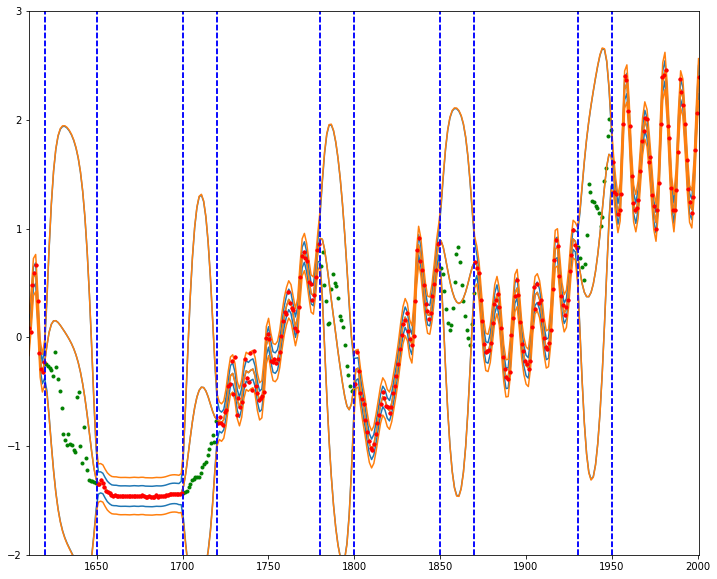

In [587]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), sharex=True)
plot_raw(m_full_gp_mat52, X, ax)
plot(m_full_gp_mat52, X, ax)

#### Plot for sparse GP- matern52 kernel and hyperparameter values optimised

In [588]:
m_sparse_gp_mat52 = GPy.core.SparseGP(X_train, Y_train, Z.copy(), kern_mat52.copy(), lik.copy())

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter


('defaulting to ', <GPy.inference.latent_function_inference.var_dtc.VarDTC object at 0x7fdbea44bf98>, 'for latent function inference')


In [589]:
m_sparse_gp_mat52.optimize('lbfgs', max_iters=600)

In [590]:
print(m_sparse_gp_mat52)


Name : sparse gp
Objective : 64.63293393876938
Number of Parameters : 53
Number of Optimization Parameters : 53
Updates : True
Parameters:
  sparse_gp.               |                value  |  constraints  |  priors
  inducing_inputs          |              (50, 1)  |               |        
  Mat52.variance           |   1.0248627447642353  |      +ve      |        
  Mat52.lengthscale        |    40.60070986705275  |      +ve      |        
  Gaussian_noise.variance  |  0.07029848483852598  |      +ve      |        


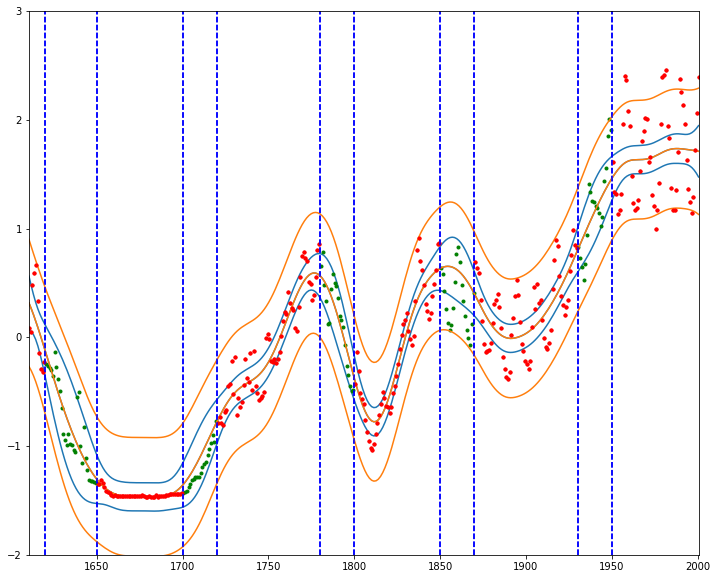

In [591]:
fig, ax = plt.subplots(1, 1, figsize=(12, 10), sharex=True)
plot_raw(m_sparse_gp_mat52, X, ax)
plot(m_sparse_gp_mat52, X, ax)

####  Plot for RBF kernel - Sparse GP 

In [596]:
m_sparse_gp_rbf = GPy.core.SparseGP(X_train, Y_train, Z.copy(), kern_rbf.copy(), lik.copy())

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters
INFO:sparse gp:Adding Z as parameter


('defaulting to ', <GPy.inference.latent_function_inference.var_dtc.VarDTC object at 0x7fdbea309320>, 'for latent function inference')


In [597]:
print(m_sparse_gp_rbf)


Name : sparse gp
Objective : 491.3492616931392
Number of Parameters : 53
Number of Optimization Parameters : 53
Updates : True
Parameters:
  sparse_gp.               |    value  |  constraints  |  priors
  inducing_inputs          |  (50, 1)  |               |        
  rbf.variance             |      1.0  |      +ve      |        
  rbf.lengthscale          |      1.0  |      +ve      |        
  Gaussian_noise.variance  |      1.0  |      +ve      |        


In [598]:
m_sparse_gp_rbf.optimize('lbfgs', max_iters=600)

In [599]:
print(m_sparse_gp_rbf)


Name : sparse gp
Objective : 64.77616275192804
Number of Parameters : 53
Number of Optimization Parameters : 53
Updates : True
Parameters:
  sparse_gp.               |                value  |  constraints  |  priors
  inducing_inputs          |              (50, 1)  |               |        
  rbf.variance             |   0.8642643314940528  |      +ve      |        
  rbf.lengthscale          |   26.053676375955188  |      +ve      |        
  Gaussian_noise.variance  |  0.07104138824264923  |      +ve      |        


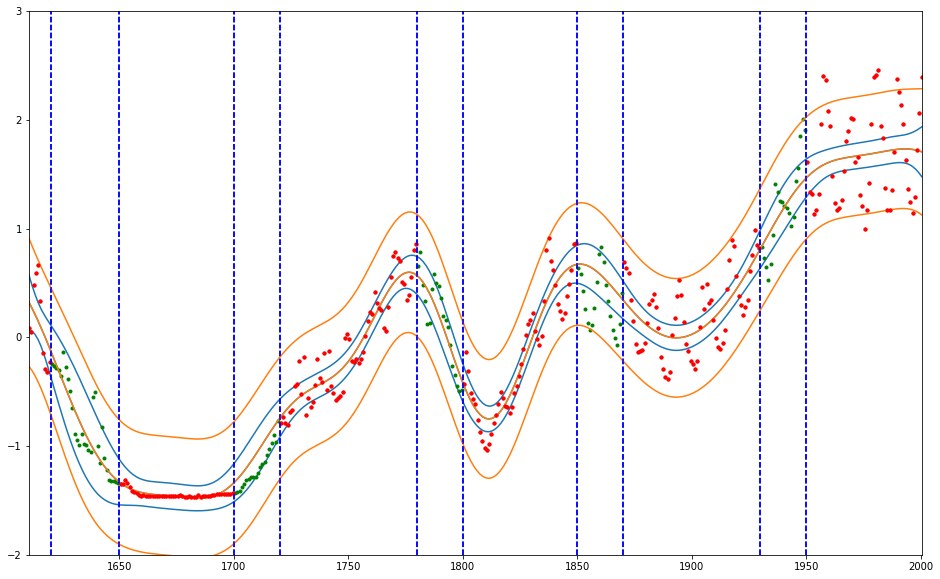

In [600]:
fig, ax = plt.subplots(1, 1, figsize=(16, 10), sharex=True)
plot_raw(m_sparse_gp_rbf, X, ax)
plot(m_sparse_gp_rbf, X, ax)

####  Plot for Full GP with RBF kernel

In [601]:
m_full_gp_rbf = GPy.core.GP(X_train, Y_train, kern_rbf.copy(), lik.copy())

INFO:GP:initializing Y
INFO:GP:initializing inference method
INFO:GP:adding kernel and likelihood as parameters


In [602]:
m_full_gp_rbf.optimize('lbfgs', max_iters=600)

In [603]:
print(m_full_gp_rbf)


Name : gp
Objective : -83.92327119233761
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  gp.                      |                 value  |  constraints  |  priors
  rbf.variance             |    0.8361840153654505  |      +ve      |        
  rbf.lengthscale          |    3.8845112500244228  |      +ve      |        
  Gaussian_noise.variance  |  0.006420189826188886  |      +ve      |        


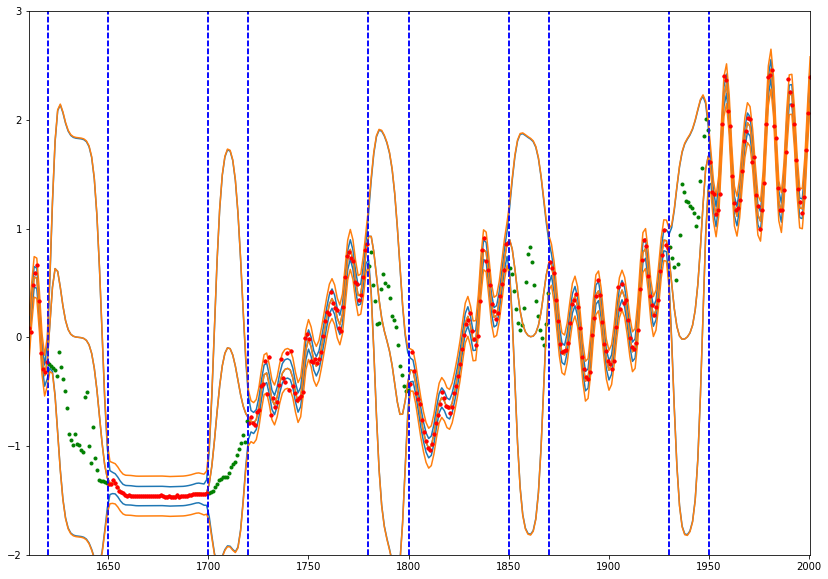

In [652]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10), sharex=True)
plot_raw(m_full_gp_rbf, X, ax)
plot(m_full_gp_rbf, X, ax)

In [605]:
mu_star, var_star = m_full_gp_rbf.predict(X_test)
RMSE_test = np.sqrt(np.mean(np.square(mu_star - Y_test)))
print(RMSE_test)

0.6726761421430525


In [621]:
def RMSE(Y_star, Y_test):
    rmse = np.sqrt(np.mean(np.square(Y_star - Y_test)))
    return rmse

def NMSE(Y_star, Y_test):
    nmse = np.mean(np.square(Y_star - Y_test)) / np.mean(np.square(Y_test - np.mean(Y_test)))
    return nmse

def MLPPD(Y_star, Y_test, var_star):
    mlppd = 0.5* (np.sum(np.square(Y_star - Y_test)/var_star + np.log(var_star) + np.log(2*np.pi))) / Y_star.size
    return mlppd


In [606]:
Y_train = (Y_train - Y_train.mean()) / Y_train.std()

In [646]:
mu_train, var_train = m_full_gp_rbf.predict(X_train)
RMSE_train = RMSE(mu_train, Y_train)
NMSE_train = NMSE(mu_train, Y_train)
MLPPD_train = MLPPD(mu_train, Y_train, var_train)
mu_star, var_star = m_full_gp_rbf.predict(X_test)
RMSE_test = RMSE(mu_star, Y_test)
NMSE_test = NMSE(mu_star, Y_test)
MLPPD_test = MLPPD(mu_star, Y_test, var_star)
print(" Full GP RBF kernel- RMSE train error: %.3f"%RMSE_train)
print(" Full GP RBF kernel- RMSE test error: %.3f"%RMSE_test)
print(" Full GP RBF kernel- NMSE train error: %.3f"%NMSE_train)
print(" Full GP RBF kernel- NMSE test error: %.3f"%NMSE_test)
print(" Full GP RBF kernel- MLPPD train error: %.3f"%MLPPD_train)
print(" Full GP RBF kernel- MLPPD test error: %.3f"%MLPPD_test)

 Full GP RBF kernel- RMSE train error: 0.085
 Full GP RBF kernel- RMSE test error: 0.673
 Full GP RBF kernel- NMSE train error: 0.007
 Full GP RBF kernel- NMSE test error: 0.547
 Full GP RBF kernel- MLPPD train error: -1.039
 Full GP RBF kernel- MLPPD test error: 0.867


In [647]:
mu_train, var_train = m_sparse_gp_rbf.predict(X_train)
RMSE_train = RMSE(mu_train, Y_train)
NMSE_train = NMSE(mu_train, Y_train)
MLPPD_train = MLPPD(mu_train, Y_train, var_train)
mu_star, var_star = m_sparse_gp_rbf.predict(X_test)
RMSE_test = RMSE(mu_star, Y_test)
NMSE_test = NMSE(mu_star, Y_test)
MLPPD_test = MLPPD(mu_star, Y_test, var_star)
print(" Sparse GP RBF kernel- RMSE train error: %.3f"%RMSE_train)
print(" Sparse GP RBF kernel- RMSE test error: %.3f"%RMSE_test)
print(" Sparse GP RBF kernel- NMSE train error: %.3f"%NMSE_train)
print(" Sparse GP RBF kernel- NMSE test error: %.3f"%NMSE_test)
print(" Sparse GP RBF kernel- MLPPD train error: %.3f"%MLPPD_train)
print(" Sparse GP RBF kernel- MLPPD test error: %.3f"%MLPPD_test)

 Sparse GP RBF kernel- RMSE train error: 0.257
 Sparse GP RBF kernel- RMSE test error: 0.228
 Sparse GP RBF kernel- NMSE train error: 0.066
 Sparse GP RBF kernel- NMSE test error: 0.063
 Sparse GP RBF kernel- MLPPD train error: 0.063
 Sparse GP RBF kernel- MLPPD test error: -0.001


In [648]:
mu_train, var_train = m_full_gp_mat52.predict(X_train)
RMSE_train = RMSE(mu_train, Y_train)
NMSE_train = NMSE(mu_train, Y_train)
MLPPD_train = MLPPD(mu_train, Y_train, var_train)
mu_star, var_star = m_full_gp_mat52.predict(X_test)
RMSE_test = RMSE(mu_star, Y_test)
NMSE_test = NMSE(mu_star, Y_test)
MLPPD_test = MLPPD(mu_star, Y_test, var_star)
print(" Full GP RBF kernel- RMSE train error: %.3f"%RMSE_train)
print(" Full GP RBF kernel- RMSE test error: %.3f"%RMSE_test)
print(" Full GP RBF kernel- NMSE train error: %.3f"%NMSE_train)
print(" Full GP RBF kernel- NMSE test error: %.3f"%NMSE_test)
print(" Full GP RBF kernel- MLPPD train error: %.3f"%MLPPD_train)
print(" Full GP RBF kernel- MLPPD test error: %.3f"%MLPPD_test)

 Full GP RBF kernel- RMSE train error: 0.076
 Full GP RBF kernel- RMSE test error: 0.496
 Full GP RBF kernel- NMSE train error: 0.006
 Full GP RBF kernel- NMSE test error: 0.298
 Full GP RBF kernel- MLPPD train error: -1.139
 Full GP RBF kernel- MLPPD test error: 0.662


In [650]:
mu_train, var_train = m_sparse_gp_mat52.predict(X_train)
RMSE_train = RMSE(mu_train, Y_train)
NMSE_train = NMSE(mu_train, Y_train)
MLPPD_train = MLPPD(mu_train, Y_train, var_train)
mu_star, var_star = m_sparse_gp_mat52.predict(X_test)
RMSE_test = RMSE(mu_star, Y_test)
NMSE_test = NMSE(mu_star, Y_test)
MLPPD_test = MLPPD(mu_star, Y_test, var_star)
print(" Sparse GP Matern52 kernel- RMSE train error: %.3f"%RMSE_train)
print(" Sparse GP Matern52 kernel- RMSE test error: %.3f"%RMSE_test)
print(" Sparse GP Matern52 kernel- NMSE train error: %.3f"%NMSE_train)
print(" Sparse GP Matern52 kernel- NMSE test error: %.3f"%NMSE_test)
print(" Sparse GP Matern52 kernel- MLPPD train error: %.3f"%MLPPD_train)
print(" Sparse GP Matern52 kernel- MLPPD test error: %.3f"%MLPPD_test)

 Sparse GP Matern52 kernel- RMSE train error: 0.254
 Sparse GP Matern52 kernel- RMSE test error: 0.229
 Sparse GP Matern52 kernel- NMSE train error: 0.064
 Sparse GP Matern52 kernel- NMSE test error: 0.063
 Sparse GP Matern52 kernel- MLPPD train error: 0.054
 Sparse GP Matern52 kernel- MLPPD test error: 0.014


In [438]:
stan_code_rff = """
functions{
    vector gp_rff_pred_rng(vector x, vector y, vector x_star, matrix A, matrix phi, vector omega, real ps,real sigma, real jitter){

        int N = rows(y);
        int M = rows(omega);
        int N_star = rows(x_star);
        vector[N_star] f_star;
        matrix[N_star, N_star] f_star_cov;

        {
            vector[N_star] f_star_mean;
            matrix[N_star, M] cosfeats_star;
            matrix[N_star, M] sinfeats_star;
            matrix[N_star, M] feats_star; 
            matrix[N_star, 2*M] phi_star;
            matrix[2*M, 2*M]A_inv;
            vector[2*M] A_inv_phi_y;
            matrix[2*M, N_star] A_inv_phi_star;

            vector[2*M]phi_y = phi'*y;

             feats_star = x_star*omega'*ps;
#              feats_star = x_star*omega';
#              feats_star = x_star*omega'*2*pi() + phase ;

            for(i in 1:N_star){
                 for(j in 1:M){
                     cosfeats_star[i,j] = cos(feats_star[i,j] );
                     sinfeats_star[i,j] = sin(feats_star[i,j] );
                     phi_star[i,j] = cosfeats_star[i,j];
                     phi_star[i,M+j] = sinfeats_star[i,j];
                }
            }

           A_inv = inverse(A);

           A_inv_phi_y = A_inv* phi_y;
#            f_star_mean = phi_star*A_inv_phi_y;
           
           f_star_mean = phi_star*A_inv_phi_y*(2./M);
           A_inv_phi_star = A_inv * phi_star';

           f_star_cov = square(sigma)*phi_star*A_inv_phi_star;
           for(i in 1:N_star){
                f_star[i] = normal_rng(f_star_mean[i], f_star_cov[i,i]);
           }
           
           
        }

       return f_star;
    }
}

data {
    int<lower=1> N;
    int<lower=1> M;
    int<lower=1> N_star;
    vector[N] x;
    vector[N] y;
    vector[N_star] x_star;
    
}

transformed data {
    real jitter = 1e-6;
    real scale;
    vector[N] f_mean = rep_vector(0, N);
    vector[M] omega; 

    scale = sqrt(2.0/M);

    for (i in 1:M){
        omega[i] = normal_rng(0,1);
    }

}

parameters{
    vector[M] b1;
    vector[M] b2;
    real<lower=0> ps;
    vector[M] bk;
    real<lower=0> phase;
    real<lower=1e-6> sigma;

}

transformed parameters {
    vector[N] f;
#     matrix[N, N] K;
    matrix[N, M] feats;
    matrix[2*M, 2*M] A;
    matrix[N, 2*M] fullfeats;
    
    { 
        matrix[N, M] cosfeats;
        matrix[N, M] sinfeats;
        vector[N] cosfeats_shift;
        vector[N] sinfeats_shift;
         feats = x * omega' * ps;
#         feats = x * omega';
#         feats = x * omega'*2*pi() + phase;

         for(i in 1:N){
             for(j in 1:M){
                 cosfeats[i,j] = cos(feats[i,j] );
                 sinfeats[i,j] = sin(feats[i,j] );
                 fullfeats[i,j] = cosfeats[i,j];
                 fullfeats[i,M+j] = sinfeats[i,j];
             }
         }

        cosfeats_shift = cosfeats * b1;
        sinfeats_shift = sinfeats * b2;
        f = (cosfeats_shift + cosfeats_shift)*scale;
        A = fullfeats'*fullfeats*square(scale);
        for(i in 1:2*M){
            A[i,i] = A[i,i] + M*square(sigma);
        }

    }
}

model {
    ps ~ normal(0, 1.0);
    bk ~ normal(0,1);
    b1 ~ normal(0.0, 1.0);
    b2 ~ normal(0.0, 1.0);
    sigma ~ normal(0.0, 0.5);
    phase ~ uniform(0.0, 2*pi());
    
    y ~ normal(f, sigma);
    
}

generated quantities{
    vector[N_star] f_star = gp_rff_pred_rng(x, y, x_star, A, fullfeats, omega, ps,sigma, jitter);
    vector[N_star] y_star;
    for(i in 1:N_star){
        y_star[i] = normal_rng(f_star[i], sigma);
    }

}
"""

In [439]:
stan_model_rff = pystan.StanModel(model_code=stan_code_rff)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3fed33c99df4be9cc738289d3594c23c NOW.


In [446]:
N_star = X_test.shape[0]
N = X_train.shape[0]

In [447]:
gp_solar_data = {'N':N, 'x':X_train.flatten(), 'y':Y_train.flatten(), 'M':100, 'N_star':N_star, 'x_star':X_test.flatten()}

In [448]:
fit_gpr_rff = stan_model_rff.sampling(data=gp_solar_data, iter=600, chains=2)

 /u/26/dhakaa1/unix/anaconda2/envs/stanpy35/lib/python3.5/site-packages/pystan/misc.py:399: FutureWarning:Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.


In [122]:
# print(fit_gpr_rff)

In [449]:
samples = fit_gpr_rff.extract(permuted=True)
# omega = samples['sigvar']
# omega_mean = np.mean(omega, axis=0)
# sigma = samples['sigma']
# sigma_mean = np.mean(sigma, axis=0)

In [450]:
f = samples['f']

In [462]:
f_star = samples['f_star']
y_star = samples['y_star']

In [463]:
f_25 = np.percentile(f, 2.5, axis=0)
f_975 = np.percentile(f, 97.5, axis=0)

In [464]:
f_star_25 = np.percentile(f_star, 2.5, axis=0)
f_star_975 = np.percentile(f_star, 97.5, axis=0)
f_star_median = np.percentile(f_star, 50, axis=0)

In [465]:
y_star_25 = np.percentile(y_star, 2.5, axis=0)
y_star_975 = np.percentile(y_star, 97.5, axis=0)

In [466]:
mu = np.mean(f_star, axis=0)
var = np.var(f_star, axis=0)

(1610.5, 2000.5)

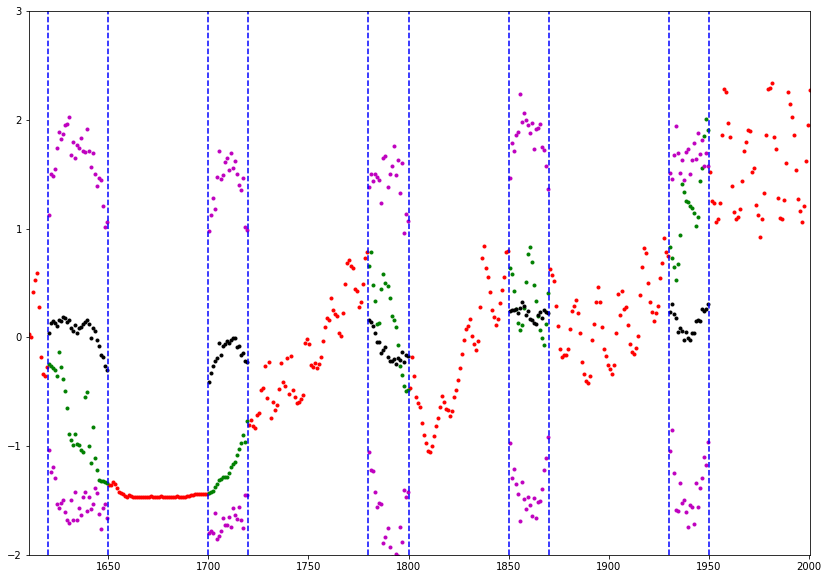

In [653]:
fig, ax = plt.subplots(1, 1, figsize=(14, 10), sharex=True)
# ax.plot(X_test, mu + 2*np.sqrt(var))
# ax.plot(X_test, mu - 2*np.sqrt(var))
ax.plot(X_train, Y_train, 'r.')
ax.plot(X_test, Y_test, 'g.')
ax.plot(X_test, mu, 'k.')
ax.plot(X_test, mu+2*var, 'm.')
ax.plot(X_test, mu-2*var, 'm.')

for i in intervals:
    ax.plot([i[0], i[0]], [-2, 3], 'b--')
    ax.plot([i[1], i[1]], [-2, 3], 'b--')
ax.set_ylim(-2, 3)
ax.set_xlim(X.min(), X.max())

In [659]:
RMSE_test = RMSE(mu, Y_test)
NMSE_test = NMSE(mu, Y_test)
MLPPD_test = MLPPD(mu, Y_test, var)
print("RMSE error: %.3f"%RMSE_test)
print("NMSE error: %.3f"%NMSE_test)
print("MLPPD error: %.3f"%MLPPD_test)

RMSE error: 0.940
NMSE error: 1.068
MLPPD error: 150.279
